### Import libraries

In [1]:
import os # operating system operations
import shutil as st # copy operations
import numpy as np # array and vector-matrix operations
import random # shuffle datas
import pickle # save and load history files
import cv2 # resize images
import matplotlib.image as mping # read RGB images
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import skimage

# required packages for our ConvNet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet152,  DenseNet201, MobileNetV2, EfficientNetB0, EfficientNetB7
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score,  precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc

### Downloading and extracting the dataset

### Global variables

In [2]:
# Categories, Path and sizes

multi_categories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] # the multiclass images categories

multi_train = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Training set'
multi_val = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Validation set'
multi_test = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Test set'

multiclass_directories = [multi_train, multi_val, multi_test]

multi_train_size = 8512
multi_val_size   = 751
multi_test_size  = 752

multi_sizes = [multi_train_size, multi_val_size, multi_test_size]

### Class for balancing the dataset and for the CNNs

In [3]:
#========================== Create a DataBalancerGenerator class, which help us to balancing the imbalanced dataset =========================#

class DataBalancerGenerator(Sequence): # inherited from Sequence

    # initialize the class members, and applying Data augmentation and Random oversampling
    def __init__(self, x, y, datagen, batch_size = 32):
    
        self.datagen    = datagen # ImageDataGenerator, which we use to Data augmentation
        self.batch_size = batch_size
        self.shape      = x.shape        
        
        datagen.fit(x)# compute quantities required for featurewise normalization  (std, mean, and principal components if ZCA whitening is applied)
        self.balanced_gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1),
                                                                           y           = to_categorical(y, num_classes = 7),
                                                                           sampler     = RandomOverSampler(),
                                                                           batch_size  = self.batch_size,
                                                                           keep_sparse = True) # balacing the dataset
    # determine the number of batches in the Sequence.
    def __len__(self):
        return self.steps_per_epoch
        
    # create batches and use Data augmentation
    def __getitem__(self, idx): # idx here is a mandatory parameter, but we don't use this.
    
        x_batch, y_batch = self.balanced_gen.__next__()
        x_batch = x_batch.reshape(-1, *self.shape[1:])
        
        return self.datagen.flow(x_batch, y_batch, batch_size = self.batch_size).next() # .flow returns an iterator, so we have to use next() method to get the batches with tuple type.

In [4]:
class SkinCancerCnn:

    # initialize the class members
    def __init__(self, image_size,multi_learning_rate, multi_batch_size, multi_decrease_lr, multi_early_stop, multi_epochs_num):
    
        self.image_size           = image_size           # the given image size (the size that we want to use  to train a model in our ConvNet)
        self.multi_learning_rate  = multi_learning_rate  # the multiclass classification model learning rate
        self.multi_batch_size     = multi_batch_size     # the multiclass classification model batch size (defines the number of samples that will be propagated through the network.)
        self.multi_decrease_lr    = multi_decrease_lr    # the multiclass classification model decrease learning rate (when this is true, the learning rate will be decreasing)
        self.multi_early_stop     = multi_early_stop     # the multiclass classification model early stopping (when this is true, the training will stop when the validation loss won't decrease)
        self.multi_epochs_num     = multi_epochs_num     # the multiclass classification models epochs number (the number of complete passes through the training dataset)
        
    # load the images and create a numpy image array, which contains all the images that we need
    @staticmethod
    def create_image_arr(img_size, path, datasets, preprocesser, mode):
    
        images = []

        for dataset in datasets:
            images_list = os.listdir(path + '/' +  dataset)
            img_label   = datasets.index(dataset) # we need to map the labels to numbers(indexes 0-6)

            for img in images_list:
                my_image = mping.imread(path + '/' + dataset + '/' + img) # read the images
                my_image = cv2.resize(my_image, (img_size, img_size),) # resize the images
                images.append([my_image, img_label]) 

        if mode == 'train':
            random.shuffle(images) # we have to shuffle the images, because if we don't, then the model start to memorize them

        X = []
        y = []

        for matrix, label in images:
            X.append(matrix)
            y.append(label)

        X = np.array(X) # we need to map the list into a numpy array
        y = np.array(y) # the corresponding labels

        if mode == 'test':
            X = preprocesser(X) # Normalize data 

        print('Image array done with shape: ' + str(X.shape)) # the numpy array (matrix) shape

        return X,y # return with the image array and the corresponding labels

    # Load the images with ImageDataGenerator which allow us to preprocess them easily
    def create_multiclass_generators(self, X, y, train_path, val_path, multi_nums_arr, preprocesser):

        # we use this ImageDataGenerator for Data augmentation (because the dataset is pretty imbalanced and we have to correct this)
        datagen = ImageDataGenerator(preprocessing_function = preprocesser,
                                     rotation_range         = 180,
                                     width_shift_range      = 0.08,
                                     height_shift_range     = 0.08,
                                     zoom_range             = 0.065,
                                     horizontal_flip        = True,
                                     vertical_flip          = True,
                                     fill_mode              = 'nearest') 
        
        batch_size = self.multi_batch_size

        balanced_gen = DataBalancerGenerator(X, y, datagen, batch_size = self.multi_batch_size) # Oversampling and Data augmentation to get more samples 
        
        val_steps = multi_nums_arr[1] // batch_size

        # we will use this generator under the training session in order to evaluate the model
        val_datagen = ImageDataGenerator(preprocessing_function = preprocesser)

        val_gen = val_datagen.flow_from_directory(val_path,
                                                  target_size = (self.image_size,self.image_size),
                                                  batch_size  = batch_size,
                                                  class_mode  = "categorical") 

        return balanced_gen, val_gen, val_steps # return with the 2 generator (which basically an iterator type) and the corresponding steps (we will use that later in the model)

    # Load the images with ImageDataGenerator which allow us to preprocess them easily
    def create_multiclass_generators_new(self, train_path, val_path, multi_nums_arr, preprocesser):

        # we use this ImageDataGenerator for Data augmentation (because the dataset is pretty imbalanced and we have to correct this)
        datagen = ImageDataGenerator(preprocessing_function = preprocesser,
                                     rotation_range     = 180,
                                     width_shift_range  = 0.08,
                                     height_shift_range = 0.08,
                                     zoom_range         = 0.065,
                                     horizontal_flip    = True,
                                     vertical_flip      = True,
                                     fill_mode          = 'nearest') 
        
        batch_size = self.multi_batch_size
        
        balanced_gen = datagen.flow_from_directory(train_path,
                                                   target_size = (self.image_size,self.image_size),
                                                   batch_size  = batch_size,
                                                   class_mode  = "categorical") 
        
        val_steps = multi_nums_arr[1] // batch_size

        # we will use this generator under the training session in order to evaluate the model
        val_datagen = ImageDataGenerator(preprocessing_function = preprocesser)

        val_gen = val_datagen.flow_from_directory(val_path,
                                                  target_size = (self.image_size,self.image_size),
                                                  batch_size  = batch_size,
                                                  class_mode  = "categorical") 

        return balanced_gen, val_gen, val_steps # return with the 2 generator (which basically an iterator type) and the corresponding steps (we will use that later in the model)

    # Create multiclass classification model with transfer learning
    def multi_class_model(self, train_gen, val_gen, val_steps, current_model, units, num_layers, dropout, globlayer, freeze_layers_num):
             
        # The pre-trained CNN
        conv_base = current_model(weights     = 'imagenet', # initialize the weights
                                  include_top = False, # we don't want to use the top layers ( we want to use our densely connected classifier)
                                  input_shape = (self.image_size, self.image_size, 3)) # the input shape( usually it's (224,224,3))
      
        # Our dataset is different to any subset of the imagenet dataset, therefore freezing will mean a decrease in accuracy
        # unfreezing some layers will allow us to optimize in the whole feature space, allowing to find better optima    

        if freeze_layers_num == 0:
            conv_base.trainable = False
        else:
            for layer in conv_base.layers[:freeze_layers_num]:
                layer.trainable = False 
        
        model = models.Sequential()
        model.add(conv_base)
        
        if globlayer:
            model.add(GlobalAveragePooling2D())

        model.add(layers.Flatten()) # flattens the 3D tensor of embeddings into a 2D tensor of shape 
        
        for i in range(num_layers):
            
            model.add(layers.Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # use Regularization and Dropout in order to reduce overfitting
            
            if dropout: 
                model.add(layers.Dropout(0.35))
                
        model.add(layers.Dense(7, activation = 'softmax')) # final layer with 7 output        
        
        # compile and run the model
        model.compile(loss      = 'categorical_crossentropy', # Multiclass, single-label classification
                      optimizer = Adam(learning_rate = self.multi_learning_rate), # use RMSprop optimizer with the given learning rate
                      metrics   = ["accuracy",
                                   tf.keras.metrics.Precision(name = 'precision'),
                                   tf.keras.metrics.Recall(name = 'recall')]) # we only care about accuracy 

        return model # return the model and the corresponding history (we will use these things later)

    # create multiclass classification model with transfer learning
    def multi_class_model_train(self, train_gen, val_gen, val_steps, current_model, units, num_layers, dropout, globlayer, freeze_layers_num, model_name):
    
        model = self.multi_class_model(train_gen,
                                       val_gen,
                                       val_steps,
                                       current_model,
                                       units,
                                       num_layers,
                                       dropout,
                                       globlayer,
                                       freeze_layers_num)
        
        callbacks = []
        
        # For TensorBoard visualisation
        #tensorboard = TensorBoard(log_dir = 'logs/{}'.format(model_name), histogram_freq = 1)
        #callbacks.append(tensorboard)
            
        # If the user want to decrease the learning rate under the training session
        if self.multi_decrease_lr:
            decrease_lr = ReduceLROnPlateau(monitor   = 'val_recall',
                                            factor    = 0.2,
                                            min_lr    = 0.0000001,
                                            patience  = 2,
                                            verbose   = 1,
                                            min_delta = 1e-6,
                                            mode      = 'max')
                                            
            callbacks.append(decrease_lr)
            
        # If the user want to use early stopping under the training session  
        if self.multi_early_stop:
            early_stop = EarlyStopping(monitor              = 'val_recall',
                                       min_delta            = 0,
                                       patience             = 3,
                                       verbose              = 0,
                                       mode                 = 'max',
                                       baseline             = None,
                                       restore_best_weights = True)
                                       
            callbacks.append(early_stop)

        history = model.fit(
                    train_gen,
                    callbacks        = callbacks,
                    epochs           = self.multi_epochs_num,
                    validation_data  = val_gen,
                    validation_steps = val_steps)

        return model, history # return the model and the corresponding history
    
    
    # Calculate and save the metrics
    @staticmethod
    def metrics_scores(y_true, y_pred, filename):
        # precision - The predictions are the baseline
        # recall - The grand truth labels are the baseline
        # f1-score - The harmonic mean of percision and recall (overall performance of the model)

        accuracy          = accuracy_score(y_true, y_pred) # How many we got right
        recall            = recall_score(y_true, y_pred, average = 'macro') # Truth labels are the baseline, All class[i] truth how many we got right
        precision         = precision_score(y_true, y_pred, average = 'macro') # All class[i] predictions how many we got right
        f1_score          = 2 * (precision * recall) / (precision + recall)
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
        mcc               = matthews_corrcoef(y_true, y_pred)
        avg               = (balanced_accuracy + f1_score + mcc) / 3.0
        
        format_accuracy          = "{:.4f}".format(accuracy)
        format_precision         = "{:.4f}".format(precision)
        format_balanced_accuracy = "{:.4f}".format(balanced_accuracy)
        format_f1_score          = "{:.4f}".format(f1_score)
        format_mcc               = "{:.4f}".format(mcc)
        format_avg               = "{:.4f}".format(avg)
        
        acc_format = "{:.2f}".format(accuracy * 100)
        avg_format = "{:.2f}".format(avg * 100)
        
        # Save the metrics
        with open(filename, 'w') as file:

            file.write("Accuracy of the total model is {:.4f}".format(accuracy) + '\n')
            file.write("Precision of the total model is {:.4f}".format(precision) + '\n')
            file.write("Recall of the total model is {:.4f}".format(recall) + '\n')
            file.write("Balanced accuracy of the total model is {:.4f}".format(balanced_accuracy) + '\n')
            file.write("F1 score of the total model is {:.4f}".format(f1_score) + '\n')
            file.write("MCC of the total model is {:.4f}".format(mcc) + '\n')  
            file.write("AVG of the total model is {:.4f}".format(avg) + '\n')  
            file.write('\n\n\n')
            file.write(format_accuracy + '\t' + format_precision + '\t' + format_balanced_accuracy + '\t' + format_f1_score + '\t' + format_mcc + '\t' + format_avg)
            file.write('\n\n')
            file.write(acc_format)
            file.write('\n')
            file.write(avg_format)
        
        
        print(classification_report(y_true, y_pred))
        
    # Plot the confusion matrix   
    @staticmethod
    def confusion_matrix(y_true, y_pred, norm, filename):
        
        plt.rcParams["figure.figsize"] = (6,4)

        cm      = confusion_matrix(y_true = y_true, y_pred = y_pred, normalize = norm)
        ax      = plt.subplot()
        
        if norm == None:
            heatmap = seaborn.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size" : 12}, fmt = 'd') 
        else:
            heatmap = seaborn.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size" : 12}) 
        
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
        ax.yaxis.set_ticklabels(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
        ax.figure.savefig(filename, dpi = 400)        
        
    # Plot the training process 
    @staticmethod    
    def plot_model(history, filename):
        
        accuracy      = history.history['accuracy']
        val_accuracy  = history.history['val_accuracy']
        
        recall     = history.history['recall']
        val_recall = history.history['val_recall']

        loss     = history.history['loss']
        val_loss = history.history['val_loss']

        fig, ax    = plt.subplots(1, 3, figsize=(20, 8))
        ax         = ax.ravel()
        num_epochs = len(history.history['loss'])

        for i, met in enumerate(['accuracy', 'recall', 'loss']):
            ax[i].plot(history.history[met])
            ax[i].plot(history.history['val_' + met])
            ax[i].set_title('Model {}'.format(met))
            ax[i].set_xlabel('epochs')
            ax[i].set_xticks(range(1,num_epochs))
            ax[i].set_ylabel(met)
            ax[i].legend(['Training ' + met, 'Validation ' + met])

        plt.savefig(filename)  
        
    # Plot ROC-AUC curve
    @staticmethod        
    def plot_ROC_AUC_curve(y_true, y_pred, filename):

        # roc curve for classes
        fpr = {}
        tpr = {}
        thresh ={}
        roc_auc = dict()

        n_class = 7
        plt.rcParams["figure.figsize"] = (12,8)

        y_t = label_binarize(y_true, classes = np.unique(y_true))

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_t[:,i], y_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            # plotting    
            plt.plot(fpr[i], tpr[i], linestyle='--', 
                     label='%s vs Rest (AUC=%0.2f)'%(SkinCancerCnn.map_labels(i),roc_auc[i]))

        plt.plot([0,1],[0,1],'b--')
        plt.xlim([0,1])
        plt.ylim([0,1.05])
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='lower right')
        plt.savefig(filename)
        plt.show()
        
        
    # Map the indexes into labels
    @staticmethod
    def map_labels(index):

        labels_dict={
          0: 'Actinic Keratoses and Intraepithelial Carcinoma', # akiec
          1: 'Basal cell carcinoma', # bcc
          2: 'Benign keratosis-like lesions', # bkl
          3: 'Dermatofibroma', # df
          4: 'Melanoma', # mel 
          5: 'Melanocytic nevi', # nv
          6: 'Vascular lesions' # vasc
        } 

        return labels_dict[index] # return with the right value
    
    


### Default models training

In [ ]:
# hyperparameters for NN
lr                = 0.00001
batch_size        = 64

my_skin_cnn = SkinCancerCnn(64, lr, batch_size, True, True, 20)


# create numpy array and generators for Multiclass
X_train, y_train = SkinCancerCnn.create_image_arr(64, multiclass_directories[0], multi_categories,  tf.keras.applications.resnet.preprocess_input, 'train')

In [ ]:
# VGG16
# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                      tf.keras.applications.vgg16.preprocess_input)

# Training process
vgg16_model, vgg16_history = my_skin_cnn.multi_class_model(VGG16, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
vgg16_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\VGG16_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.vgg16.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = vgg16_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/VGG16_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/VGG16_metrics.txt')
SkinCancerCnn.plot_model(vgg16_history, 'plots/VGG16_default_plot.jpg')

In [ ]:
# InceptionV3
# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.inception_v3.preprocess_input)

# Training process
inceptionv3_model, inceptionv3_history = my_skin_cnn.multi_class_model(InceptionV3, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
inceptionv3_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\InceptionV3_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.inception_v3.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = inceptionv3_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/InceptionV3_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/InceptionV3_metrics.txt')
SkinCancerCnn.plot_model(inceptionv3_history, 'plots/InceptionV3_default_plot.jpg')

In [ ]:
# ResNet50

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.resnet.preprocess_input)
    
# Training process
resnet50_model, resnet50_history = my_skin_cnn.multi_class_model(ResNet50, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
resnet50_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\ResNet50_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = resnet50_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/ResNet50_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/ResNet50_metrics.txt')
SkinCancerCnn.plot_model(resnet50_history, 'plots/ResNet50_default_plot.jpg')

In [ ]:
# ResNet152
# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                      tf.keras.applications.resnet.preprocess_input)

# Training process
resnet152_model, resnet152_history = my_skin_cnn.multi_class_model(ResNet152, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
resnet152_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\ResNet152_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = resnet152_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/ResNet152_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/ResNet152_metrics.txt')
SkinCancerCnn.plot_model(resnet152_history, 'plots/ResNet152_default_plot.jpg')

In [ ]:
# DenseNet201

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.densenet.preprocess_input)

# Training process
densenet201_model, densenet201_history = my_skin_cnn.multi_class_model(DenseNet201, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
densenet201_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\DenseNet201_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.densenet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = densenet201_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/DenseNet201_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/DenseNet201_metrics.txt')
SkinCancerCnn.plot_model(densenet201_history, 'plots/DenseNet201_default_plot.jpg')

In [ ]:
# MobileNetV2

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.mobilenet_v2.preprocess_input)

# Training process
mobilenetv2_model, mobilenetv2_history = my_skin_cnn.multi_class_model(MobileNetV2, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
mobilenetv2_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\MobileNetV2_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.mobilenet_v2.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = mobilenetv2_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/MobileNetV2_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/MobileNetV2_metrics.txt')
SkinCancerCnn.plot_model(mobilenetv2_history, 'plots/MobileNetV2_default_plot.jpg')

In [ ]:
# EfficientNetB0

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb0_model, efficientnetb0_history = my_skin_cnn.multi_class_model(EfficientNetB0, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
efficientnetb0_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\EfficientNetB0_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.efficientnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = efficientnetb0_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/EfficientNetB0_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/EfficientNetB0_metrics.txt')
SkinCancerCnn.plot_model(efficientnetb0_history, 'plots/EfficientNetB0_default_plot.jpg')

Found 751 images belonging to 7 classes.
Epoch 1/15
626/626 [==============================] - 369s 563ms/step - loss: 0.9711 - accuracy: 0.6465 - val_loss: 0.9962 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 2/15
626/626 [==============================] - 347s 553ms/step - loss: 0.7283 - accuracy: 0.7336 - val_loss: 0.9889 - val_accuracy: 0.6605 - lr: 1.0000e-04
Epoch 3/15
626/626 [==============================] - 343s 547ms/step - loss: 0.6574 - accuracy: 0.7604 - val_loss: 0.8512 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 4/15
626/626 [==============================] - 342s 546ms/step - loss: 0.5954 - accuracy: 0.7847 - val_loss: 0.8845 - val_accuracy: 0.6932 - lr: 1.0000e-04
Epoch 5/15
626/626 [==============================] - 344s 549ms/step - loss: 0.5858 - accuracy: 0.7892 - val_loss: 0.8622 - val_accuracy: 0.7074 - lr: 1.0000e-04
Epoch 6/15
626/626 [==============================] - 344s 548ms/step - loss: 0.5545 - accuracy: 0.7996 - val_loss: 0.8204 - val_accuracy: 0.724

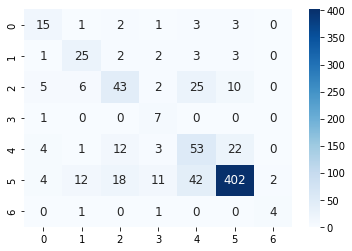

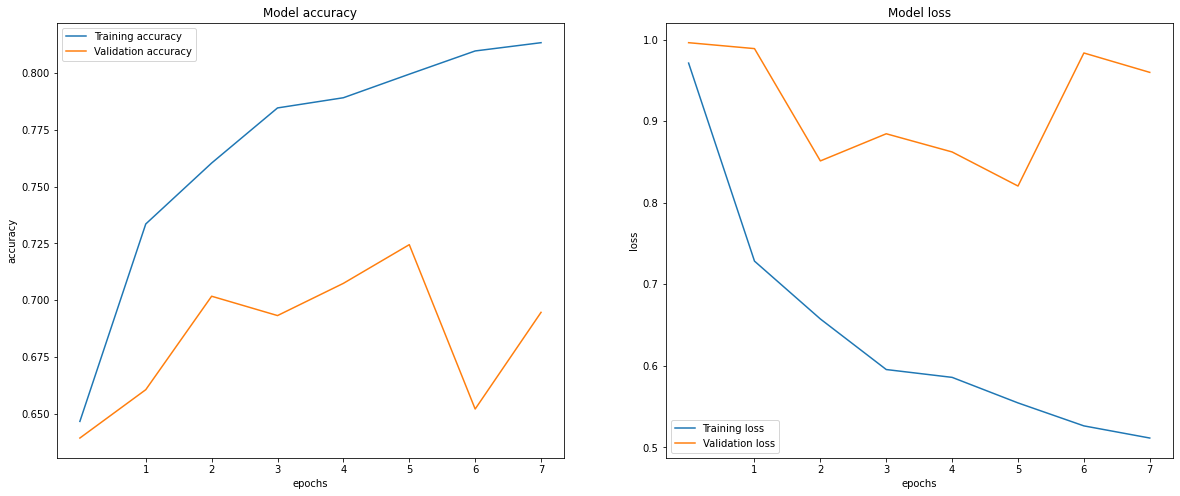

In [7]:
# EfficientNetB7

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb7_model, efficientnetb7_history = my_skin_cnn.multi_class_model(EfficientNetB7, train_multi_generator, val_multi_generator, multi_val_steps)

# Save the model
efficientnetb7_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\EfficientNetB7_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.efficientnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = efficientnetb7_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'heatmaps/EfficientNetB7_default_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/EfficientNetB7_metrics.txt')
SkinCancerCnn.plot_model(efficientnetb7_history, 'plots/EfficientNetB7_default_plot.jpg')

### Optimized models training

In [26]:
# VGG16 optimized model

current_model     = VGG16
lr                = 0.00001
batch_size        = 32
units             = 512
num_layers        = 1
dropout           = False
globlayer         = True
freeze_layers_num = 14
model_name        = 'VGG16'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.vgg16.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.vgg16.preprocess_input)

# Training process
vgg16_optimized_model, vgg16_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)
# Save the model
vgg16_optimized_model.save('D:\\MSC_szakdolgozat\\MSC_szakdoga\\models\\vgg16_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.vgg16.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = vgg16_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/vgg16_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/vgg16_metrics.txt')
SkinCancerCnn.plot_model(vgg16_optimized_history, 'plots/vgg16_plot.jpg')

In [ ]:
# InceptionV3_optimized
# Multi class NN

current_model     = InceptionV3
lr                = 0.00001
batch_size        = 64
units             = 256
num_layers        = 3
dropout           = False
globlayer         = True
freeze_layers_num = 50
model_name        = 'InceptionV3_optimized'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.inception_v3.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.inception_v3.preprocess_input)

# Training process
inceptionv3_optimized_model, inceptionv3_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)

# Save the model
inceptionv3_optimized_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\InceptionV3_optimized_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.inception_v3.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = inceptionv3_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

# Confusion matrix, metrics, plots
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/InceptionV3_optimized_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/InceptionV3_optimized_metrics.txt')
SkinCancerCnn.plot_model(inceptionv3_optimized_history, 'plots/InceptionV3_optimized_plot.jpg')

In [ ]:
# ResNet50 optimized model

current_model     = ResNet50
lr                = 0.00001
batch_size        = 64
units             = 384
num_layers        = 2
dropout           = False
globlayer         = False
freeze_layers_num = 90
model_name        = 'ResNet50_optimized2'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.resnet.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.resnet.preprocess_input)

# Training process
resnet50_optimized_model, resnet50_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)
# Save the model
resnet50_optimized_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\ResNet50_optimized2_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = resnet50_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/ResNet50_optimized2_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/ResNet50_optimized2_metrics.txt')
SkinCancerCnn.plot_model(resnet50_optimized_history, 'plots/ResNet50_optimized2_plot.jpg')

In [ ]:
# ResNet152_optimized
# Multi class NN

current_model     = ResNet152
lr                = 0.00001
batch_size        = 64
units             = 128
num_layers        = 3
dropout           = False
globlayer         = False
freeze_layers_num = 200
model_name        = 'ResNet152_new_optimized'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.resnet.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.resnet.preprocess_input)

# Training process
resnet152_optimized_model, resnet152_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)

# Save the model
resnet152_optimized_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\ResNet152_new_optimized_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = resnet152_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/ResNet152_new_optimized_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/ResNet152_new_optimized_metrics.txt')
SkinCancerCnn.plot_model(resnet152_optimized_history, 'plots/ResNet152_new_optimized_plot.jpg')

In [ ]:
# DenseNet201_optimized
# Multi class NN

current_model     = DenseNet201
units             = 384
num_layers        = 2
dropout           = True
globlayer         = False
freeze_layers_num = 200
model_name        = 'DenseNet201_optimized'


train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.densenet.preprocess_input)

# Training process
densenet201_optimized_model, densenet201_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)

# Save the model
densenet201_optimized_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\DenseNet201_optimized_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.densenet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = densenet201_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/DenseNet201_optimized_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/DenseNet201_optimized_metrics.txt')
SkinCancerCnn.plot_model(densenet201_optimized_history, 'plots/DenseNet201_optimized_plot.jpg')

In [ ]:
# MobileNetV2 optimized model

current_model     = MobileNetV2
lr                = 0.00001
batch_size        = 32
units             = 256
num_layers        = 1
dropout           = False
globlayer         = False
freeze_layers_num = 35
model_name        = 'MobileNetV2'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.mobilenet_v2.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.mobilenet_v2.preprocess_input)

# Training process
mobilenetv2_optimized_model, mobilenetv2_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)
# Save the model
mobilenetv2_optimized_model.save('D:\\MSC_szakdolgozat\\MSC_szakdoga\\models\\mobilenetv2_224x224_batch64__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.mobilenet_v2.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = mobilenetv2_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/mobilenetv2_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/mobilenetv2_metrics.txt')
SkinCancerCnn.plot_model(mobilenetv2_optimized_history, 'plots/mobilenetv2_plot.jpg')

In [ ]:
# EfficientNetB0_optimized_weights
# Multi class NN

current_model     = EfficientNetB0
lr                = 0.00001
batch_size        = 64
units             = 384
num_layers        = 3
dropout           = False
globlayer         = False
freeze_layers_num = 100
model_name        = 'EfficientNetB0_optimized'

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 20)

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.efficientnet.preprocess_input, 'train')




train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb0_optimized_model, efficientnetb0_optimized_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                                       val_multi_generator,
                                                                                                       multi_val_steps, 
                                                                                                       current_model,
                                                                                                       units,
                                                                                                       num_layers,
                                                                                                       dropout,
                                                                                                       globlayer,
                                                                                                       freeze_layers_num,
                                                                                                       model_name)

# Save the model
efficientnetb0_optimized_model.save('D:\\MSC_szakdolgozat\\MSC_szakdoga\\models\\EfficientNetB0_optimized_new_224x224_batch32__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.efficientnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = efficientnetb0_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

# Confusion matrix, metrics, plots
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/EfficientNetB0_new_optimized_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/EfficientNetB0_optimized_new_metrics.txt')
SkinCancerCnn.plot_model(efficientnetb0_optimized_history, 'plots/EfficientNetB0_optimized_new_plot.jpg')

In [ ]:
# EfficientNetB7_optimized_weights
# Multi class NN

current_model     = EfficientNetB7
lr                = 0.00001
batch_size        = 8
units             = 128
num_layers        = 3
dropout           = True
globlayer         = True
freeze_layers_num = 400
model_name        = 'EfficientNetB7_optimized_weights'

my_skin_cnn = SkinCancerCnn(600, lr, batch_size, True, True, 20)

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators_new(multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb7_optimized_model, efficientnetb7_optimized_history = my_skin_cnn.multi_class_model_train_new(train_multi_generator,
                                                                                                       val_multi_generator,
                                                                                                       multi_val_steps, 
                                                                                                       current_model,
                                                                                                       units,
                                                                                                       num_layers,
                                                                                                       dropout,
                                                                                                       globlayer,
                                                                                                       freeze_layers_num,
                                                                                                       model_name)

# Save the model
efficientnetb7_optimized_model.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\EfficientNetB7_optimized_new_2_600x600_batch32__0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(600, multi_test, multi_categories, tf.keras.applications.efficientnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = efficientnetb7_optimized_model.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

# Confusion matrix, metrics, plots
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/EfficientNetB7_optimized_new_2_new_conf_mat_num.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/EfficientNetB7_optimized_new_2_metrics.txt')
SkinCancerCnn.plot_model(efficientnetb7_optimized_history, 'plots/EfficientNetB7_optimized_new_2_plot.jpg')

### Hyperparameter search

In [ ]:
def build_model(hp):
    
    current_model     = EfficientNetB0
    units             = hp.Int("units", min_value = 128, max_value = 512, step = 128)
    num_layers        = hp.Int("layers", min_value = 1, max_value = 3)
    dropout           = hp.Boolean("dropout")
    globlayer         = hp.Boolean("globlayer")
    freeze_layers_num = hp.Int("freeze_layers_num", min_value = 0, max_value = 200, step = 50)
    
    # call existing model-building code with the hyperparameter values.
    model = my_skin_cnn.multi_class_model(train_multi_generator,
                                          val_multi_generator,
                                          multi_val_steps,
                                          current_model,
                                          units,
                                          num_layers,
                                          dropout,
                                          globlayer,
                                          freeze_layers_num)

    return model

In [ ]:
lr                = 0.00001
batch_size        = 32

my_skin_cnn = SkinCancerCnn(224, lr, batch_size, True, True, 15)

# create numpy array and generators for Multiclass
X_train, y_train = SkinCancerCnn.create_image_arr(224, multiclass_directories[0], multi_categories,  tf.keras.applications.efficientnet.preprocess_input, 'train')

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)


build_model(kt.HyperParameters())

In [ ]:
tuner = kt.BayesianOptimization(build_model,
                                max_trials = 15,
                                # Do not resume the previous search in the same directory.
                                overwrite = True,
                                objective = kt.Objective("val_recall", direction=  "max"),
                                # Set a directory to store the intermediate results.
                                directory = "my_dir")


callbacks = []


decrease_lr = ReduceLROnPlateau(monitor   = 'val_recall',
                                factor    = 0.2,
                                min_lr    = 0.0000001,
                                patience  = 2,
                                verbose   = 1,
                                min_delta = 1e-6,
                                mode      = 'max')

early_stop = EarlyStopping(monitor              = 'val_recall',
                           min_delta            = 0,
                           patience             = 3,
                           verbose              = 0,
                           mode                 = 'max',
                           baseline             = None,
                           restore_best_weights = True)

callbacks.append(decrease_lr)
callbacks.append(early_stop)
callbacks.append(keras.callbacks.TensorBoard("loggings_bayes_efficientnetb0"))    

tuner.search(train_multi_generator,
             callbacks        = callbacks,
             epochs           = 15,
             validation_data  = val_multi_generator,
             validation_steps = multi_val_steps)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units is {best_hps.get('units')} 
and the optimal number of layers is {best_hps.get('layers')}
and the optimal use of dropout is {best_hps.get('dropout')}
and the optimal globlayer is {best_hps.get('globlayer')}
and the optimal freeze_layers_num is {best_hps.get('freeze_layers_num')}.
""")

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model


hypermodel.fit(train_multi_generator,
               callbacks        = callbacks,
               epochs           = 15,
               validation_data  = val_multi_generator,
               validation_steps = multi_val_steps)

In [ ]:
hypermodel.save('C:\\Users\\habon\\Desktop\\python_jupyter\\MSC_Szakdoga\\models\\ResNet50_optimized_224x224_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred         = hypermodel.predict(X_test)
y_pred         = [np.argmax(element) for element in y_pred]

SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/ResNet50_optimized_conf_mat.jpg')
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/ResNet50_optimized_metrics.txt')

In [ ]:
# Optimized hyperparameters for NN
img_size          = 224
lr                = 0.00001
batch_size        = 64
epochs_num        = 15
units             = best_hps.get('units')
num_layers        = best_hps.get('layers')         
dropout           = best_hps.get('dropout')
globlayer         = best_hps.get('globlayer')
freeze_layers_num = best_hps.get('freeze_layers_num')

# Save the hyperparameters
with open('hyperparameters_vgg16.txt', 'w') as file:
    file.write('lr ' + str(lr) + '\n')
    
    file.write('batch_size ' + str(batch_size) + '\n')
    file.write('units ' + str(units) + '\n')
    file.write('num_layers ' + str(num_layers) + '\n')
    file.write('dropout ' + str(dropout) + '\n')
    file.write('globlayer ' + str(globlayer) + '\n')
    file.write('freeze_layers_num ' + str(freeze_layers_num) + '\n')

### Loading the default models

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        25
           1       0.46      0.58      0.51        36
           2       0.51      0.63      0.56        91
           3       0.23      0.50      0.31        10
           4       0.47      0.64      0.54        95
           5       0.93      0.79      0.85       486
           6       0.57      0.89      0.70         9

    accuracy                           0.72       752
   macro avg       0.54      0.63      0.57       752
weighted avg       0.77      0.72      0.74       752



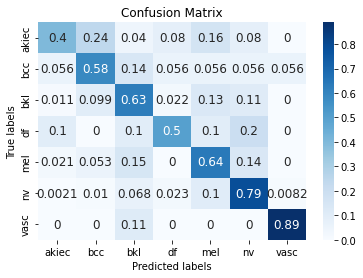

In [5]:
# VGG16
model_vgg16 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\VGG16_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.vgg16.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_vgg16.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/VGG16_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/VGG16_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/VGG16_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.29      0.64      0.40        25
           1       0.48      0.61      0.54        36
           2       0.50      0.42      0.46        91
           3       0.37      0.70      0.48        10
           4       0.38      0.40      0.39        95
           5       0.90      0.82      0.86       486
           6       0.47      0.78      0.58         9

    accuracy                           0.70       752
   macro avg       0.48      0.62      0.53       752
weighted avg       0.74      0.70      0.71       752



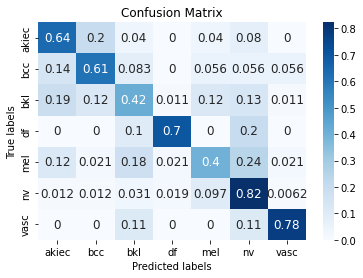

In [6]:
# InceptionV3
model_inceptionv3 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\InceptionV3_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.inception_v3.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_inceptionv3.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/InceptionV3_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/InceptionV3_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/InceptionV3_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.69      0.44      0.54        25
           1       1.00      0.64      0.78        36
           2       0.55      0.70      0.62        91
           3       0.50      0.70      0.58        10
           4       0.47      0.61      0.53        95
           5       0.92      0.85      0.88       486
           6       0.88      0.78      0.82         9

    accuracy                           0.78       752
   macro avg       0.71      0.67      0.68       752
weighted avg       0.81      0.78      0.78       752



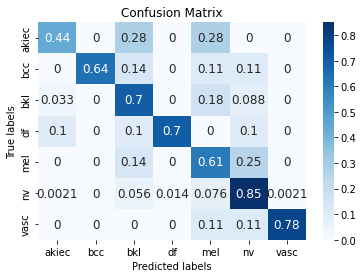

In [7]:
# ResNet50
model_resnet50 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\ResNet50_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_p = model_resnet50.predict(X_test)
y_pred = [np.argmax(element) for element in y_p]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/ResNet50_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/ResNet50_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/ResNet50_default_heatmap_normalized.jpg')

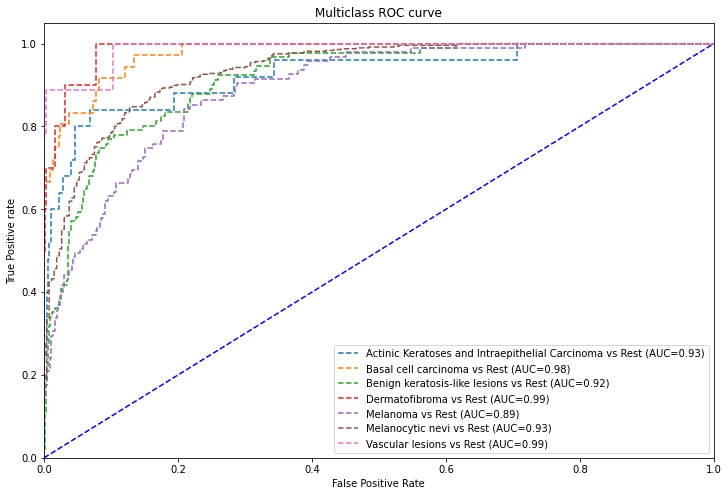

In [8]:
# ResNet50 ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, y_p, 'ROC-AUC/default/ResNet50_default_ROC_AUC.jpg') 

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.71      0.48      0.57        25
           1       0.68      0.53      0.59        36
           2       0.52      0.73      0.61        91
           3       0.64      0.90      0.75        10
           4       0.42      0.73      0.53        95
           5       0.95      0.77      0.85       486
           6       0.70      0.78      0.74         9

    accuracy                           0.74       752
   macro avg       0.66      0.70      0.66       752
weighted avg       0.80      0.74      0.76       752



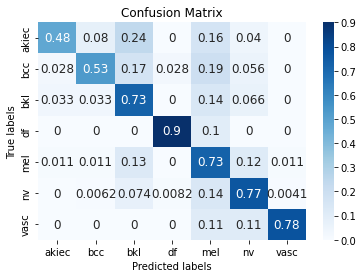

In [9]:
# ResNet152
model_resnet152 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\ResNet152_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet152.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/ResNet152_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/ResNet152_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/ResNet152_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.69      0.44      0.54        25
           1       0.52      0.83      0.64        36
           2       0.63      0.45      0.53        91
           3       0.56      0.50      0.53        10
           4       0.48      0.59      0.53        95
           5       0.91      0.89      0.90       486
           6       0.80      0.89      0.84         9

    accuracy                           0.78       752
   macro avg       0.65      0.66      0.64       752
weighted avg       0.79      0.78      0.78       752



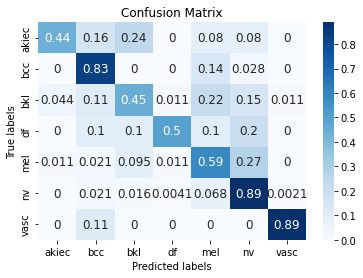

In [10]:
# DenseNet201
model_densenet201 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\DenseNet201_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.densenet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_densenet201.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/DenseNet201_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/DenseNet201_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/DenseNet201_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.66      0.53      0.58        36
           2       0.39      0.77      0.52        91
           3       0.55      0.60      0.57        10
           4       0.38      0.56      0.45        95
           5       0.93      0.70      0.80       486
           6       0.50      0.78      0.61         9

    accuracy                           0.67       752
   macro avg       0.57      0.61      0.57       752
weighted avg       0.76      0.67      0.69       752



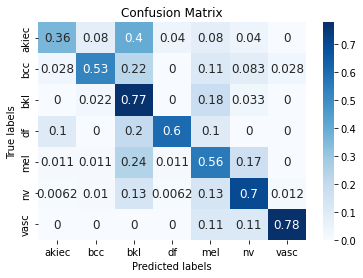

In [11]:
# MobileNetV2
model_mobilenetv2 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\MobileNetV2_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.mobilenet_v2.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_mobilenetv2.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/MobileNetV2_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/MobileNetV2_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/MobileNetV2_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.67      0.32      0.43        25
           1       0.68      0.58      0.63        36
           2       0.56      0.69      0.62        91
           3       0.35      0.70      0.47        10
           4       0.42      0.61      0.50        95
           5       0.92      0.81      0.86       486
           6       0.78      0.78      0.78         9

    accuracy                           0.74       752
   macro avg       0.62      0.64      0.61       752
weighted avg       0.79      0.74      0.76       752



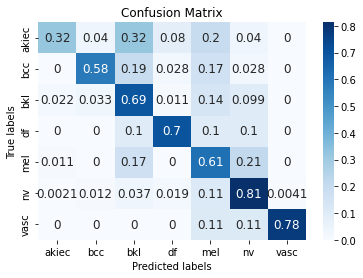

In [12]:
# EfficientNetB0
model_efficientnetb0 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\EfficientNetB0_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb0.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/EfficientNetB0_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/EfficientNetB0_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/EfficientNetB0_default_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        25
           1       0.54      0.69      0.61        36
           2       0.56      0.47      0.51        91
           3       0.31      0.90      0.46        10
           4       0.42      0.56      0.48        95
           5       0.91      0.82      0.86       486
           6       0.78      0.78      0.78         9

    accuracy                           0.73       752
   macro avg       0.58      0.69      0.61       752
weighted avg       0.77      0.73      0.74       752



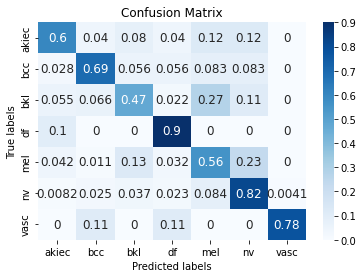

In [13]:
# EfficientNetB7
model_efficientnetb7 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_DEFAULT_MODELS\\EfficientNetB7_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb7.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/EfficientNetB7_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/EfficientNetB7_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/EfficientNetB7_default_heatmap_normalized.jpg')

### Loading the optimized models

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.80      0.48      0.60        25
           1       0.84      0.58      0.69        36
           2       0.59      0.87      0.70        91
           3       0.88      0.70      0.78        10
           4       0.70      0.53      0.60        95
           5       0.92      0.93      0.93       486
           6       1.00      0.89      0.94         9

    accuracy                           0.84       752
   macro avg       0.82      0.71      0.75       752
weighted avg       0.85      0.84      0.83       752



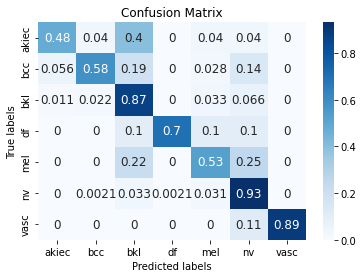

In [7]:
# VGG16_optimized
model_vgg16_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\VGG16_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.vgg16.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_vgg16_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/VGG16_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/VGG16_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/VGG16_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        25
           1       0.90      0.72      0.80        36
           2       0.67      0.84      0.75        91
           3       1.00      0.70      0.82        10
           4       0.62      0.67      0.65        95
           5       0.95      0.92      0.93       486
           6       1.00      0.89      0.94         9

    accuracy                           0.86       752
   macro avg       0.86      0.76      0.80       752
weighted avg       0.87      0.86      0.86       752



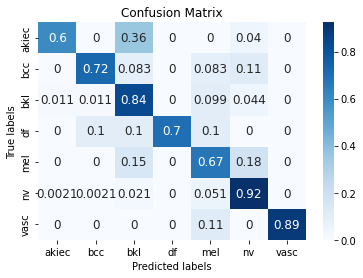

In [8]:
# InceptionV3_optimized
model_inceptionv3_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_inceptionv3_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/InceptionV3_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/InceptionV3_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/InceptionV3_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.94      0.60      0.73        25
           1       0.87      0.75      0.81        36
           2       0.72      0.76      0.74        91
           3       0.67      1.00      0.80        10
           4       0.69      0.68      0.69        95
           5       0.92      0.94      0.93       486
           6       1.00      0.89      0.94         9

    accuracy                           0.86       752
   macro avg       0.83      0.80      0.81       752
weighted avg       0.87      0.86      0.86       752



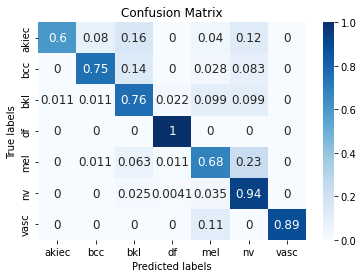

In [9]:
# ResNet50_optimized
model_resnet50_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\ResNet50_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet50_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/ResNet50_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/ResNet50_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/ResNet50_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        25
           1       0.89      0.69      0.78        36
           2       0.64      0.81      0.71        91
           3       0.64      0.90      0.75        10
           4       0.64      0.64      0.64        95
           5       0.93      0.90      0.91       486
           6       0.89      0.89      0.89         9

    accuracy                           0.84       752
   macro avg       0.78      0.79      0.78       752
weighted avg       0.85      0.84      0.84       752



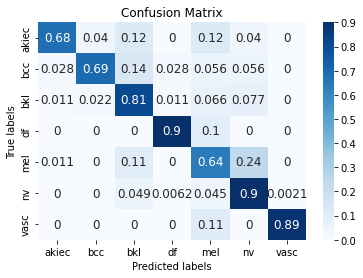

In [10]:
# ResNet152_optimized
model_resnet152_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\ResNet152_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet152_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/ResNet152_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/ResNet152_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/ResNet152_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.79      0.44      0.56        25
           1       0.85      0.78      0.81        36
           2       0.61      0.81      0.69        91
           3       0.75      0.90      0.82        10
           4       0.52      0.65      0.58        95
           5       0.95      0.86      0.90       486
           6       0.67      0.89      0.76         9

    accuracy                           0.81       752
   macro avg       0.73      0.76      0.73       752
weighted avg       0.84      0.81      0.82       752



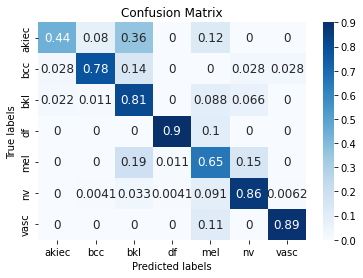

In [11]:
# DenseNet201_optimized
model_densenet201_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\DenseNet201_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.densenet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_densenet201_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/DenseNet201_optimizedmetrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/DenseNet201_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/DenseNet201_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       1.00      0.28      0.44        25
           1       0.77      0.56      0.65        36
           2       0.48      0.85      0.62        91
           3       0.29      0.50      0.37        10
           4       0.50      0.62      0.56        95
           5       0.95      0.81      0.88       486
           6       0.80      0.89      0.84         9

    accuracy                           0.76       752
   macro avg       0.69      0.64      0.62       752
weighted avg       0.82      0.76      0.77       752



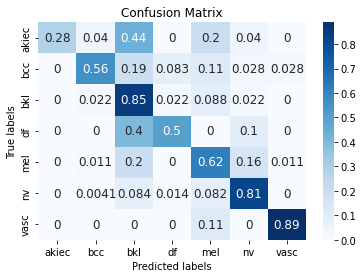

In [12]:
# MobileNetV2_optimized
model_mobilenetv2_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\MobileNetV2_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.mobilenet_v2.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_mobilenetv2_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/MobileNetV2_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/MobileNetV2_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/MobileNetV2_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.92      0.48      0.63        25
           1       0.92      0.67      0.77        36
           2       0.69      0.89      0.78        91
           3       0.58      0.70      0.64        10
           4       0.57      0.74      0.65        95
           5       0.96      0.89      0.92       486
           6       0.89      0.89      0.89         9

    accuracy                           0.85       752
   macro avg       0.79      0.75      0.75       752
weighted avg       0.87      0.85      0.85       752



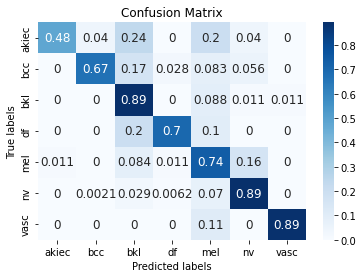

In [13]:
# EfficientNetB0_optimized
model_efficientnetb0_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\EfficientNetB0_optimized_224x224_batch32_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb0_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/EfficientNetB0_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/EfficientNetB0_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/EfficientNetB0_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       0.94      0.64      0.76        25
           1       0.93      0.75      0.83        36
           2       0.66      0.80      0.73        91
           3       0.82      0.90      0.86        10
           4       0.66      0.71      0.68        95
           5       0.93      0.92      0.93       486
           6       1.00      0.89      0.94         9

    accuracy                           0.86       752
   macro avg       0.85      0.80      0.82       752
weighted avg       0.87      0.86      0.86       752



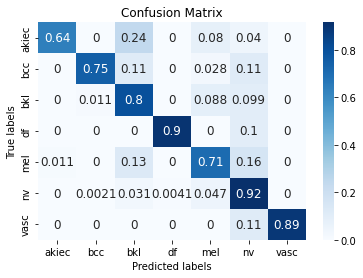

In [14]:
# EfficientNetB7_optimized
model_efficientnetb7_optimized = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\EfficientNetB7_optimized_224x224_batch32_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_p = model_efficientnetb7_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_p]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/EfficientNetB7_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/EfficientNetB7_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/EfficientNetB7_optimized_heatmap_normalized.jpg')

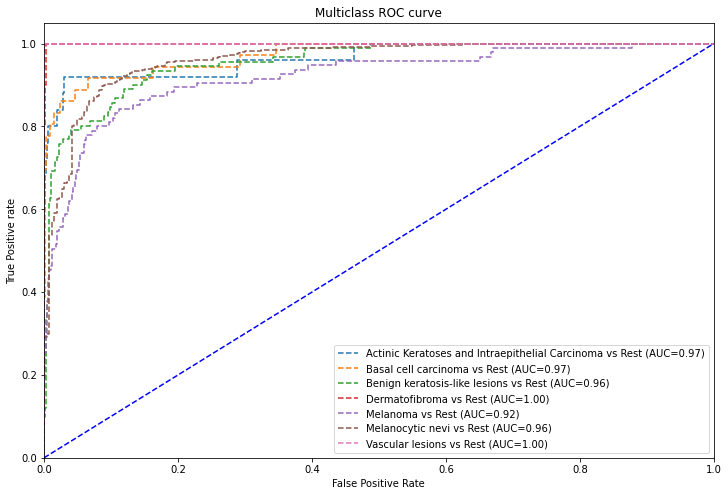

In [15]:
# EfficientNetB7_optimized ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, y_p, 'ROC-AUC/optimized/EfficientNetB7_optimized_ROC_AUC.jpg') 

### Weighted ensemble model

Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        25
           1       0.97      0.86      0.91        36
           2       0.77      0.81      0.79        91
           3       0.91      1.00      0.95        10
           4       0.76      0.75      0.75        95
           5       0.94      0.96      0.95       486
           6       1.00      0.89      0.94         9

    accuracy                           0.90       752
   macro avg       0.91      0.84      0.87       752
weighted avg       0.90      0.90      0.90       752



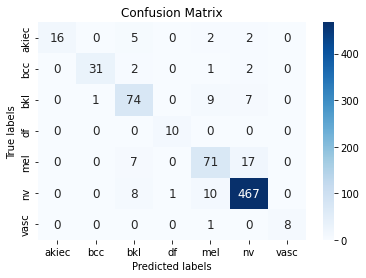

In [25]:
model_efficientnetb7_ensemble = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\EfficientNetB7_optimized_224x224_batch32_0.00001lr.h5')
model_resnet50_ensemble       = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\ResNet50_optimized_224x224_batch64_0.00001lr.h5')
model_inceptionv3_ensemble    = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
X_test2,_      = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
X_test3,_      = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images


pred_efficientnet = model_efficientnetb7_ensemble.predict(X_test)
pred_resnet       = model_resnet50_ensemble.predict(X_test2)
pred_inception    = model_inceptionv3_ensemble.predict(X_test3)
preds = [pred_efficientnet, pred_resnet, pred_inception]
preds = np.array(preds)

# Weighted
weights = [0.5, 0.7, 0.4]

# Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, weighted_ensemble_prediction, 'metrics/ensemble/ensemble_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, 'true', 'heatmaps/ensemble/ensemble_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, None, 'heatmaps/ensemble/ensemble_heatmap_normalized.jpg')

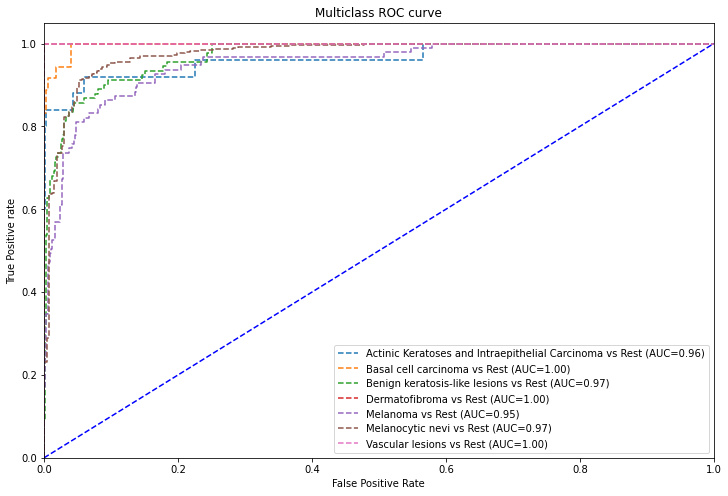

In [26]:
# ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, weighted_preds, 'ROC-AUC/ensemble/ensemble_ROC_AUC.jpg') 

#### Grid search for optimal weights

In [ ]:
# Grid search for weights

max_acc = 0.0

w1_opt = 0.0
w2_opt = 0.0
w3_opt = 0.0

for w1 in range(0,9):
    for w2 in range(0,9):
        for w3 in range(0,9):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            accuracy          = accuracy_score(y_true, wted_ensemble_pred) # How many we got right
            recall            = recall_score(y_true, wted_ensemble_pred, average = 'macro') # Truth labels are the baseline, All class[i] truth how many we got right
            precision         = precision_score(y_true, wted_ensemble_pred, average = 'macro') # All class[i] predictions how many we got right
            f1_score          = 2 * (precision * recall) / (precision + recall)
            balanced_accuracy = balanced_accuracy_score(y_true, wted_ensemble_pred)
            mcc               = matthews_corrcoef(y_true, wted_ensemble_pred)
            
            AVG = (balanced_accuracy + f1_score + mcc) / 3.0
            
            if AVG > max_acc:
                max_acc = AVG
                w1_opt = w1 / 10.0
                w2_opt = w2 / 10.0
                w3_opt = w3 / 10.0
            print(AVG)
            
print('Best weights: ' + str(w1_opt) + ' ' + str(w2_opt) + ' ' + str(w3_opt) + ' with accuracy: ' + str(max_acc))            
             

### Plots for metrics

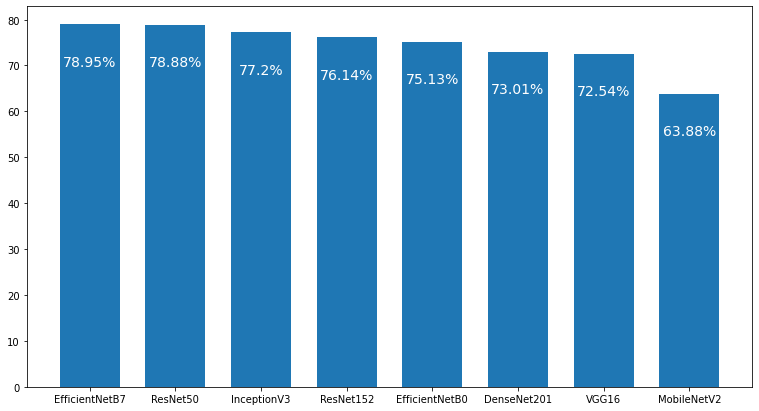

In [29]:
plt.rcParams["figure.figsize"] = (13,7)

models_default_acc = ['DenseNet201', 'ResNet50', 'EfficientNetB0', 'ResNet152', 'EfficientNetB7', 'VGG16', 'InceptionV3', 'MobileNetV2']
default_acc = [77.53, 77.53, 74.34, 73.80, 73.14, 72.47, 70.21, 67.02]
models_default_avg = ['ResNet50', 'ResNet152', 'DenseNet201', 'EfficientNetB7', 'EfficientNetB0', 'VGG16', 'MobileNetV2', 'InceptionV3']
default_avg = [65.90, 65.53, 63.59, 61.50, 62.08, 58.79, 56.76, 55.48]

models_optimized_acc = ['ResNet50', 'EfficientNetB7',  'InceptionV3', 'EfficientNetB0', 'ResNet152', 'VGG16','DenseNet201', 'MobileNetV2']
optimized_acc = [86.30, 85.77, 85.77, 84.57, 83.78, 83.78, 81.25, 76.06]
models_optimized_avg = ['EfficientNetB7', 'ResNet50', 'InceptionV3', 'ResNet152', 'EfficientNetB0', 'DenseNet201', 'VGG16', 'MobileNetV2']
optimized_avg = [78.95, 78.88, 77.20, 76.14, 75.13, 73.01, 72.54, 63.88]

models_ensemble_avg = ['eERI', 'EfficientNetB7', 'ResNet50', 'InceptionV3', 'ResNet152', 'EfficientNetB0', 'DenseNet201', 'VGG16', 'MobileNetV2']
ensemble_avg = [84.49, 78.95, 78.88, 77.20, 76.14, 75.13, 73.01, 72.54, 63.88]

x  = np.arange(len(models_optimized_avg))
y  = optimized_avg
#color = (0.8, 0.1, 0.1, 0.8)
width = 0.7
fig, ax = plt.subplots()

pps = ax.bar(x, y, width, align='center')
plt.xticks(x, models_optimized_avg)

for p in pps:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2, y=height - 9,
      s="{}%".format(height),
      ha='center', fontsize=14, color = 'white')

plt.show()
fig.savefig('metrics_plot/optimized/optimized_avg.jpg')


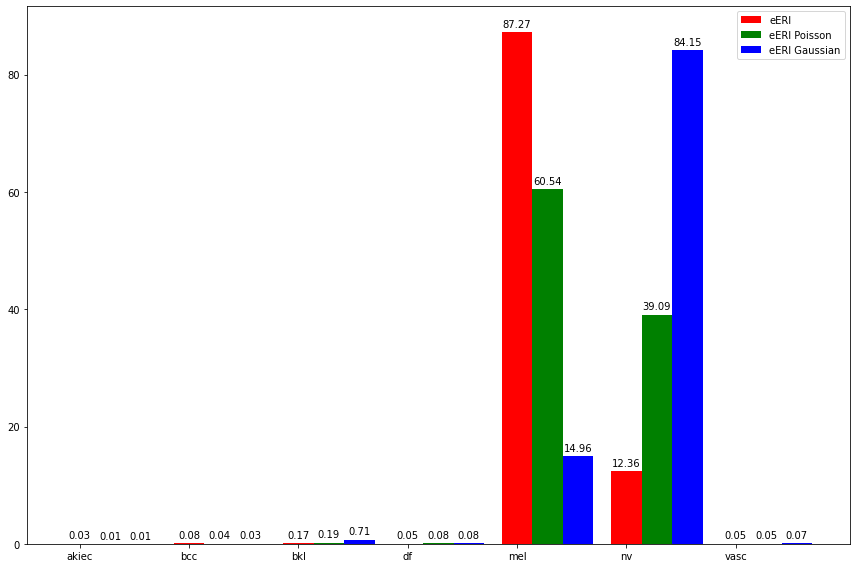

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,8)

labels = [ 'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

model_origin  = [0.03, 0.08, 0.17, 0.05, 87.27, 12.36, 0.05]

model_poisson = [0.01, 0.04, 0.19, 0.08, 60.54, 39.09, 0.05]

model_gauss = [0.01, 0.03, 0.71, 0.08, 14.96, 84.15, 0.07]

x       = np.arange(len(labels))  # the label locations
width   = 0.28  # the width of the bars
fig, ax = plt.subplots()

bar1 = ax.bar(x, model_origin, width, color = 'r', label = 'eERI')
bar2 = ax.bar(x+width, model_poisson, width, color='g', label = 'eERI Poisson')
bar3 = ax.bar(x+width*2, model_gauss, width, color = 'b', label = 'eERI Gaussian')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(bar1, padding=3)
ax.bar_label(bar2, padding=3)
ax.bar_label(bar3, padding=3)

fig.tight_layout()
fig.savefig('bbox_like.jpg')


plt.show()

### Gaussian and Poisson noise

In [36]:
def create_perturbated_folders(path, mode):

    directories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] # the multiclass images categories
    images_path = []

    for directory in directories:
        for img in os.listdir(path + '/' + directory):
            images_path.append(os.path.join(path,directory,img))


    for img_path in images_path:
        img = skimage.io.imread(img_path)
        gimg = skimage.util.random_noise(img, mode=mode)
        skimage.io.imsave(img_path, gimg)

In [38]:
poisson_path  = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Poisson test set'
gaussian_path = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Gaussian test set'

create_perturbated_folders(poisson_path, 'poisson')
create_perturbated_folders(gaussian_path, 'gaussian')

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [39]:
def adversarial_black_box_perturbation(path, perturbation, mode):

    model_efficientnetb7 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\EfficientNetB7_optimized_224x224_batch32_0.00001lr.h5')
    model_resnet50       = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\ResNet50_optimized_224x224_batch64_0.00001lr.h5')
    model_inceptionv3    = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

    multi_test = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\' + path

    X_test, y_true = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
    X_test2,_      = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
    X_test3,_      = SkinCancerCnn.create_image_arr(224, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images

    pred_efficientnet = model_efficientnetb7.predict(X_test)
    pred_resnet       = model_resnet50.predict(X_test2)
    pred_inception    = model_inceptionv3.predict(X_test3)
    preds = [pred_efficientnet, pred_resnet, pred_inception]
    preds = np.array(preds)

    #weighted average
    weights = [0.5, 0.7, 0.4]

    #Use tensordot to sum the products of all elements over specified axes.
    weighted_preds               = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

    SkinCancerCnn.metrics_scores(y_true, weighted_ensemble_prediction, 'metrics/' + mode + '/' + perturbation + '.txt')
    SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, 'true', 'heatmaps/Perturbation/' + perturbation + '.jpg')

Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       1.00      0.28      0.44        25
           1       0.94      0.42      0.58        36
           2       0.75      0.68      0.71        91
           3       0.53      0.80      0.64        10
           4       0.74      0.69      0.72        95
           5       0.87      0.96      0.92       486
           6       1.00      0.67      0.80         9

    accuracy                           0.84       752
   macro avg       0.83      0.64      0.69       752
weighted avg       0.85      0.84      0.83       752



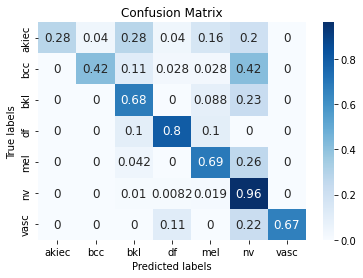

In [40]:
adversarial_black_box_perturbation('Poisson test set', 'Possion_perturbation_eERI', 'poisson')

Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
Image array done with shape: (752, 224, 224, 3)
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.89      0.22      0.36        36
           2       0.57      0.51      0.54        91
           3       0.47      0.70      0.56        10
           4       0.60      0.38      0.46        95
           5       0.80      0.96      0.88       486
           6       1.00      0.44      0.62         9

    accuracy                           0.76       752
   macro avg       0.76      0.46      0.50       752
weighted avg       0.76      0.76      0.72       752



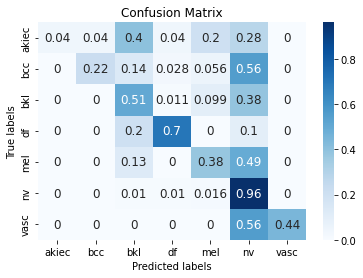

In [42]:
adversarial_black_box_perturbation('Gaussian test set', 'Gaussian_perturbation_eERI', 'gauss')

### FGSM white box untargeted attack

In [6]:
model_efficientnetb7 = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\EfficientNetB7_optimized_224x224_batch32_0.00001lr.h5')
model_resnet50       = keras.models.load_model('D:\\MSC_szakdolgozat\\BEST_OPTIMIZED_MODELS\\ResNet50_optimized_224x224_batch64_0.00001lr.h5')

#### Helper functions for FGSM

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def preprocess(image, preprocess):
    
    image = tf.image.resize(image, (224, 224))
    image = preprocess(image)
    image = image[None, ...]
    return image

def create_adversarial_pattern(input_image, input_label, model):
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

def mapping_labels(index):
    
    labels_dict={
      0: 'akiec', # akiec
      1: 'bcc', # bcc
      2: 'bkl', # bkl
      3: 'df', # df
      4: 'mel', # mel 
      5: 'nv', # nv
      6: 'vasc' # vasc
    } 
    
    return labels_dict[index]

def mapping_indices(index):
    
    labels_dict={
      'akiec' : 0, # akiec
      'bcc': 1, # bcc
      'bkl': 2, # bkl
      'df': 3, # df
      'mel': 4, # mel 
      'nv': 5, # nv
      'vasc': 6 # vasc
    } 
    
    return labels_dict[index]

def display_images(image, model):
    
    predictions = model.predict(image)
    label = np.argmax(predictions, axis = 1)
    confidence = float(max((model.predict(image))[0]))
    #plt.figure()
    #plt.imshow(image[0]  / 255.0) #*0.5+0.5
    #plt.imshow(image[0] *0.5+0.5) #*0.5+0.5
    #print(label)
    #plt.title('\n {} : {:.2f}% Confidence'.format(mapping_labels(label[0]), confidence*100))
    #plt.show()
    return label

In [8]:
path        = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Test set'
directories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] # the multiclass images categories
y_true      = []
y_pred      = []
ind         = 0

for directory in directories:
    for img in os.listdir(path + '/' + directory):
        
        img_path  = os.path.join(path,directory,img)
        image_raw = tf.io.read_file(img_path)
        image     = tf.image.decode_image(image_raw)

        image       = preprocess(image, tf.keras.applications.resnet.preprocess_input)
        image_probs = model_resnet50.predict(image)
        label       = np.argmax(image_probs, axis = 1)

        skin_index = mapping_indices(directory)
        y_true.append(skin_index)
        
        label      = tf.one_hot(skin_index, image_probs.shape[-1])
        label      = tf.reshape(label, (1, image_probs.shape[-1]))

        perturbations = create_adversarial_pattern(image, label, model_resnet50)

        epsilons = [0.5]

        for i, eps in enumerate(epsilons):
            adv_x = image + eps*perturbations            
            pred_label = display_images(adv_x, model_resnet50)
            y_pred.append(pred_label[0])
        ind += 1
        print('The current image is: ' + str(ind))


The current image is: 1
The current image is: 2
The current image is: 3
The current image is: 4
The current image is: 5
The current image is: 6
The current image is: 7
The current image is: 8
The current image is: 9
The current image is: 10
The current image is: 11
The current image is: 12
The current image is: 13
The current image is: 14
The current image is: 15
The current image is: 16
The current image is: 17
The current image is: 18
The current image is: 19
The current image is: 20
The current image is: 21
The current image is: 22
The current image is: 23
The current image is: 24
The current image is: 25
The current image is: 26
The current image is: 27
The current image is: 28
The current image is: 29
The current image is: 30
The current image is: 31
The current image is: 32
The current image is: 33
The current image is: 34
The current image is: 35
The current image is: 36
The current image is: 37
The current image is: 38
The current image is: 39
The current image is: 40
The curre

The current image is: 321
The current image is: 322
The current image is: 323
The current image is: 324
The current image is: 325
The current image is: 326
The current image is: 327
The current image is: 328
The current image is: 329
The current image is: 330
The current image is: 331
The current image is: 332
The current image is: 333
The current image is: 334
The current image is: 335
The current image is: 336
The current image is: 337
The current image is: 338
The current image is: 339
The current image is: 340
The current image is: 341
The current image is: 342
The current image is: 343
The current image is: 344
The current image is: 345
The current image is: 346
The current image is: 347
The current image is: 348
The current image is: 349
The current image is: 350
The current image is: 351
The current image is: 352
The current image is: 353
The current image is: 354
The current image is: 355
The current image is: 356
The current image is: 357
The current image is: 358
The current 

The current image is: 637
The current image is: 638
The current image is: 639
The current image is: 640
The current image is: 641
The current image is: 642
The current image is: 643
The current image is: 644
The current image is: 645
The current image is: 646
The current image is: 647
The current image is: 648
The current image is: 649
The current image is: 650
The current image is: 651
The current image is: 652
The current image is: 653
The current image is: 654
The current image is: 655
The current image is: 656
The current image is: 657
The current image is: 658
The current image is: 659
The current image is: 660
The current image is: 661
The current image is: 662
The current image is: 663
The current image is: 664
The current image is: 665
The current image is: 666
The current image is: 667
The current image is: 668
The current image is: 669
The current image is: 670
The current image is: 671
The current image is: 672
The current image is: 673
The current image is: 674
The current 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.04      0.03      0.03        36
           2       0.00      0.01      0.01        91
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        95
           5       0.42      0.18      0.25       486
           6       0.14      0.11      0.12         9

    accuracy                           0.12       752
   macro avg       0.09      0.05      0.06       752
weighted avg       0.28      0.12      0.16       752



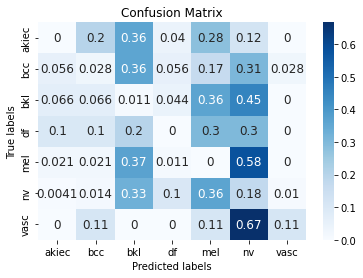

In [9]:
y_t = np.array(y_true)
y_p = np.array(y_pred)


SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/FGSM/ResNet50_fgsm_metrics_0_5.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/Perturbation/ResNet50_fgsm_conf_mat_0_5.png')